# Imports

In [5]:
import sys
sys.path.insert(1, '/home/ssclafani/pone/software/Plenum/core/')

In [6]:
import pickle
import numpy as np
import warnings
import healpy as hp
from copy import deepcopy
from matplotlib import pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2
from scipy.interpolate import RegularGridInterpolator
import histlite as hl
from scipy.optimize import minimize
warnings.filterwarnings("ignore")


In [7]:
import astropy
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [8]:
from matplotlib.colors import LogNorm
#plt.set_cmap("cividis")

# Source parameters

In [9]:
pi0_norm = 1.03e-13 #5.47e-13   
pi0_spectrum = 2.7
E0 = 1e3
LIVETIME = 10 * 365 * 86400
'''
pi0_norm = 2.18e-18 #1.9e-16 #2.43e-18  #unbias corrected bias corrected 2.18e-18 #1/(GeV s  cm^2)
pi0_spectrum = 2.7
E0 = 1e5
LIVETIME = 10 * 365 * 86400'''

'\npi0_norm = 2.18e-18 #1.9e-16 #2.43e-18  #unbias corrected bias corrected 2.18e-18 #1/(GeV s  cm^2)\npi0_spectrum = 2.7\nE0 = 1e5\nLIVETIME = 10 * 365 * 86400'

In [10]:
base_dir = '/home/ssclafani/pone/data/'

In [11]:
nside= 128

In [12]:
pi0_weight_per_bin = np.load(base_dir + 'Fermi-LAT_pi0_map.npy', encoding='latin1')
pi0_weight_per_bin /= pi0_weight_per_bin.sum()
print(sum(pi0_weight_per_bin))
if nside != 128:
    print('NSIDE: {}'.format(nside))
    pi0_weight_per_bin = hp.ud_grade(pi0_weight_per_bin, nside)
    
pi0_flux_per_pixel = pi0_norm * pi0_weight_per_bin #* hp.nside2pixarea(nside) 

0.9999999999999891


In [13]:
sum(pi0_flux_per_pixel)

1.0300000000000198e-13

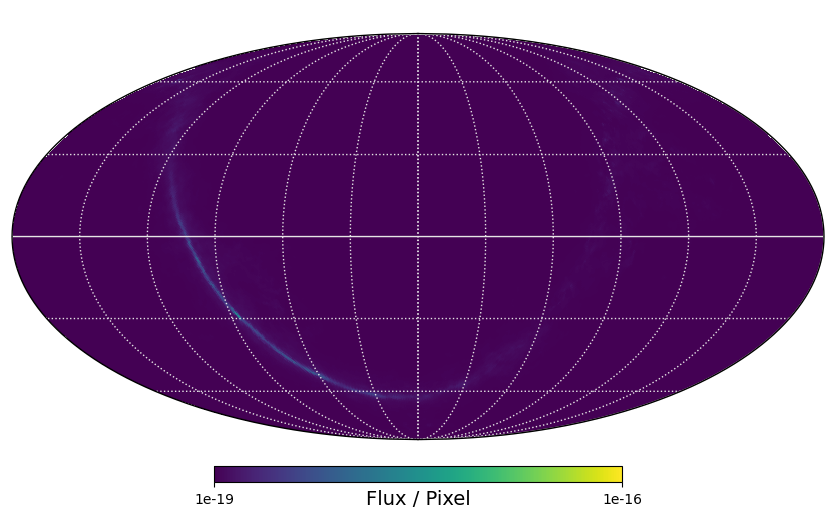

In [14]:
hp.mollview (pi0_flux_per_pixel, unit='Flux / Pixel', rot=(180,0), title=' ', min=1e-19,max=1e-16)
hp.graticule(c='0.9')

# Functions

In [15]:
def rotate_events(azimuth, zenith):
    PONE = {
        "lon": -123.3656 * u.deg,
        "lat":48.4284 * u.deg} #48.4284 * u.deg}
    loc = EarthLocation(lon= PONE['lon'], lat= PONE['lat'])
    times = np.random.uniform(size=1, low=53005, high=53371)
    t = Time(times, format='mjd')
    coords = astropy.coordinates.AltAz(az=azimuth*u.rad, alt=(np.pi/2 - zenith)*u.rad, 
                                   obstime = t, location=loc)
    

    eq = astropy.coordinates.SkyCoord(coords)
    ra = eq.icrs.ra.rad
    dec = eq.icrs.dec.rad
    return ra, dec


In [16]:
def rotate_events_to_local(ra,dec, time=None):
    PONE = {
        "lon": -123.3656 * u.deg,
        "lat":48.4284 * u.deg} #48.4284 * u.deg}
    loc = EarthLocation(lon= PONE['lon'], lat= PONE['lat'])
    times = np.random.uniform(size=len(ra), low=53005, high=53371)
    if time:
        t = Time(time, format='mjd')
        #eq = astropy.coordinates.SkyCoord(ra=ra*u.rad, dec=dec*u.rad)
        #loc = eq.transform_to(astropy.coordinates.AltAz(obstime=t, location=loc))
    else:
        t = Time(times, format='mjd') #54508#random day
    eq = astropy.coordinates.SkyCoord(ra=ra*u.rad, dec=dec*u.rad)
    loc = eq.transform_to(astropy.coordinates.AltAz(obstime=t, location=loc))
    zenith = np.pi/2 - loc.alt.rad
    azimuth = loc.az.rad
    return azimuth, zenith


In [17]:
def get_mids(bins, ext=False):
    """ Calculate the bin mids from an array of bins """
    res = (bins[1:] + bins[:-1]) * 0.5
    if ext==False:
        return res
    else:
        res[0], res[-1] = bins[0], bins[-1]
        return res

In [18]:
def energy_smearing(ematrix, ev):
    """Translate a matrix with axis in true energy to reconstructed energy"""
    return (ematrix @ ev.T).T

In [19]:
def atmo_background(aeff_factor_bckg, bckg_flux_vals, smear_energy=False, smooth_bkg=False):
    """Calculate the number of neutrinos of atmospheric background flux as a function reconstructed energy"""
    if smear_energy:
        return energy_smearing(normed_kvals, aeff_factor_bckg * bckg_flux_vals)
    else:
        angres = np.linspace(1,.05,25)
        if smooth_bkg:
            '''smeared_template = np.ndarray((hp.nside2npix(nside), len(emids)))
            for i, angerr in enumerate(angres):
                template = aeff_factor_bckg * averaged_map #smeared_bkg_flux_per_pixel
                smeared_template[:,i] = hp.smoothing(template[:,i], sigma=np.radians(0))'''''
            return aeff_factor_bckg * averaged_map
        else:
            
            return aeff_factor_bckg * bckg_flux_per_pixel

In [20]:
def array_source_interp(dec, array, local=True):
    """Take a 2D array and interpolate its values
    based on a value (dec) on the second axis"""
    if local:
        low_ind = np.digitize(np.cos(dec), coszen_bins) - 1

    else:
        low_ind = np.digitize(np.sin(dec), coszen_bins) - 1

    
    if low_ind >= (len(coszen_mids)-1):
        array_interp = array[:, -1]
    elif low_ind == 0:
        array_interp = array[:, low_ind]
    else:
        if coszen_mids[low_ind] > np.sin(dec):
            low_ind -= 1
        array_interp = np.zeros(len(array))
        for i in range(len(array)):
            array_interp[i] = np.interp(
                np.sin(dec),
                [coszen_mids[low_ind], coszen_mids[low_ind + 1]],
                [array[i, low_ind], array[i, low_ind + 1]],
            )
    return array_interp


# Get the effective area

In [44]:
h2d = np.load('../data/PONE_nu_effa_70_string_eq.npy', allow_pickle=True)[()]
h2d_local = np.load('../data/PONE_nu_effa_70_string.npy', allow_pickle=True)[()]

#h2d = np.load(base_dir + 'pstracks_nu_effa.npy', allow_pickle=True)[()]
h2d

Hist(25 bins in [2.0,7.000000000000004], 49 bins in [-1.0,1.0], with sum 73844.22012624065, 96 empty bins, and 0 non-finite values)

In [45]:
h2d = h2d.gaussian_filter(sigma=.8)
h2d_local = h2d_local.gaussian_filter(sigma=.8)

In [46]:
h2d_local

Hist(25 bins in [2.0,7.000000000000004], 49 bins in [-1.0,1.0], with sum 73844.22012624067, 0 empty bins, and 0 non-finite values)

In [47]:
logE_bins = h2d.bins[0]
coszen_bins = h2d.bins[1]
aeff_2d = 1e4*h2d.values #values are in m^2 not cm^2 

In [48]:
aeff_2d_local = 1e4*h2d_local.values

In [51]:
from aeff_calculations import setup_aeff_grid, aeff_rotation
from settings import poles  # coordinates of a couple of detectors

# this is local azimuth
azi_bins = np.linspace(0, np.pi * 2, num=101)
azi_mids = (azi_bins[1:] + azi_bins[:-1]) * 0.5
azi_width = azi_bins[1:] - azi_bins[:-1]
## cosT_bins_raw = bins in cos(theta) of effective area (usually -1 ... 1)

k = "P-ONE"  # select the right coordinates for P-ONE
# setup evaluation grids
grid2d, eq_coords = setup_aeff_grid(
    aeff_2d_local,  # make sure eff-area has the matching axes in cos(t) and azimuth
    get_mids(coszen_bins),
    azi_mids,
    azi_width,
)

aeff_eq = (
    aeff_rotation(
        poles[k]["lat"],  # coordinates of P-ONE: latitude
        poles[k]["lon"],  # coordinates of P-ONE: longitude
        eq_coords,
        grid2d,
        azi_width,
    )
    #* 1e4
)  # m^2 -> cm^2, depends if you need this translation to cm^2 or not

(2.0, 7.0)

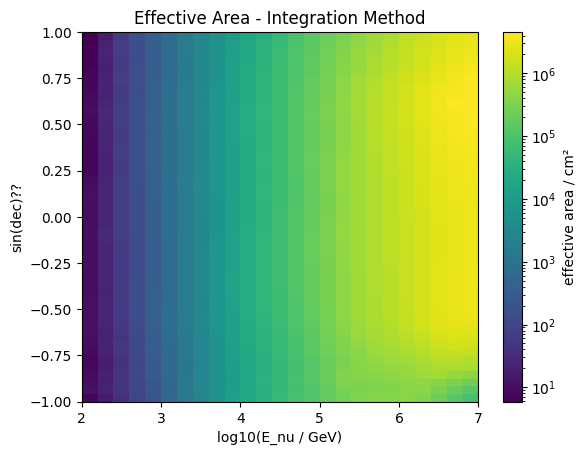

In [81]:
plt.pcolormesh(logE_bins, coszen_bins, aeff_eq.T[::-1], norm=LogNorm())
cb = plt.colorbar()
cb.set_label("effective area / cm²")
plt.ylabel("sin(dec)??")
plt.xlabel("log10(E_nu / GeV)")
plt.title('Effective Area - Integration Method')
plt.xlim(2, 7)

In [82]:
aeff_2d_local = 1e4*h2d_local.values

In [83]:
# use only upgoing data to mimick up-going muon track data set
#with open("../resources/tabulated_logE_sindec_aeff_full.pckl", "rb") as f:
#    logE_bins, sindec_bins, aeff_2d = pickle.load(f)
#h2d = np.load('/home/steve/pone/data/PONE_nu_effa_70_string.npy')
#logE_bins = h2d.bins

logE_mids = get_mids(logE_bins)
# cut at E=10⁹GeV
logE_bins = logE_bins
aeff_2d = aeff_2d
logE_mids = logE_mids


ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

coszen_mids = get_mids(coszen_bins)
coszen_width = np.diff(coszen_bins)

print(len(emids), "log_10(energy) bins")
print(len(coszen_mids), "declination bins")


25 log_10(energy) bins
49 declination bins


(2.0, 7.0)

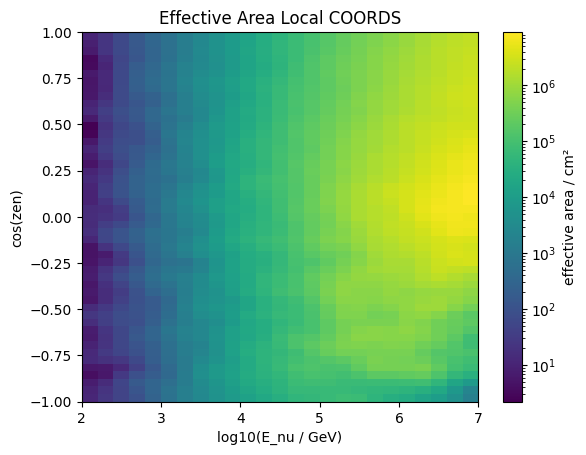

In [84]:
plt.pcolormesh(logE_bins, coszen_bins, aeff_2d_local.T, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("effective area / cm²")
plt.ylabel("cos(zen)")
plt.xlabel("log10(E_nu / GeV)")
plt.title('Effective Area Local COORDS')
plt.xlim(2, 7)

(2.0, 7.0)

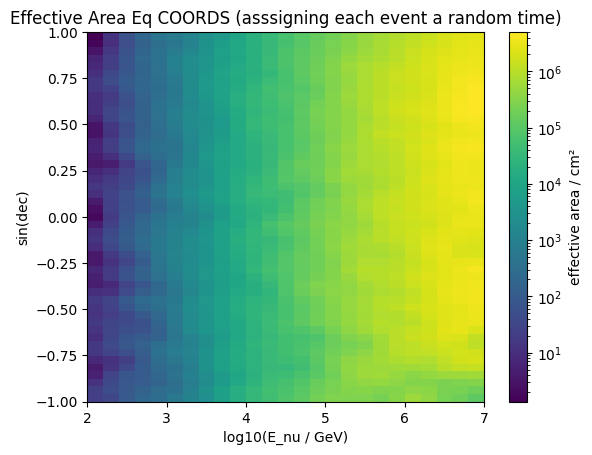

In [85]:
plt.pcolormesh(logE_bins, coszen_bins, aeff_2d.T, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("effective area / cm²")
plt.ylabel("sin(dec)")
plt.xlabel("log10(E_nu / GeV)")
plt.title('Effective Area Eq COORDS (asssigning each event a random time)')

plt.xlim(2, 7)

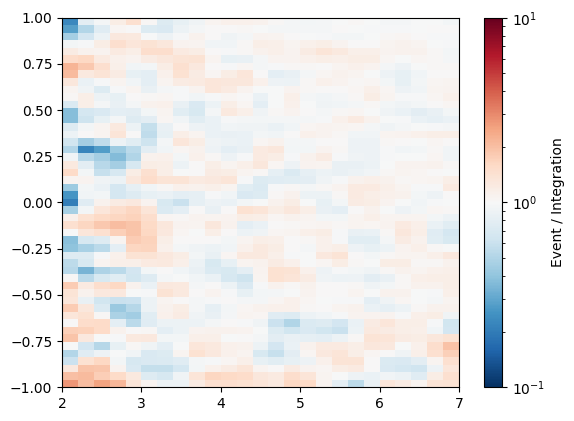

In [86]:
plt.pcolormesh(logE_bins, coszen_bins, aeff_2d.T / aeff_eq.T[::-1] , norm=LogNorm(vmin=1e-1, vmax=1e1),  cmap='RdBu_r')
cb = plt.colorbar()
cb.set_label("Event / Integration")

In [92]:
aeff_2d = aeff_eq.T[::-1].T

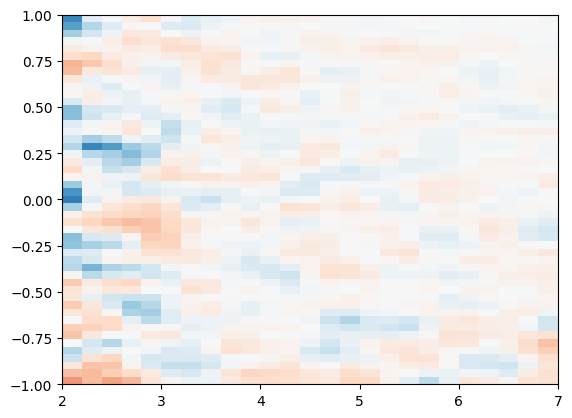

In [91]:
plt.pcolormesh(logE_bins, coszen_bins, (aeff_2d / aeff_eq.T[::-1].T).T, norm=LogNorm(vmin=1e-1, vmax=1e1),  cmap='RdBu_r')

# Background

In [93]:
# MCEQ
with open('/home/ssclafani/pone/software/Plenum/resources//MCEq_flux.pckl', "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# re-bin the atmospheric background flux
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_total"]) #+ flux_def["mu_total"] )
)
# baseline evaluation
ss, em = np.meshgrid(coszen_mids, emids)
bckg_flux_vals = np.exp(rgi((em, ss))).T

(2.0, 7.0)

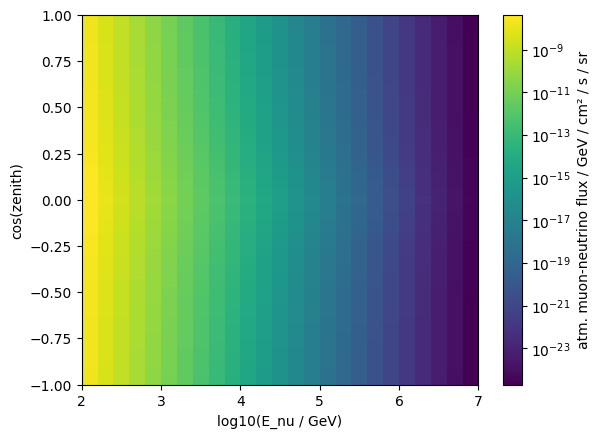

In [94]:
plt.pcolormesh(logE_bins, coszen_bins, bckg_flux_vals, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr")
plt.ylabel("cos(zenith)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 7)

In [176]:
grid2d, eq_coords = setup_aeff_grid(
    bckg_flux_vals.T,  # make sure eff-area has the matching axes in cos(t) and azimuth
    get_mids(coszen_bins),
    azi_mids,
    azi_width,
)

bkg_eq = (
    aeff_rotation(
        poles[k]["lat"],  # coordinates of P-ONE: latitude
        poles[k]["lon"],  # coordinates of P-ONE: longitude
        eq_coords,
        grid2d,
        azi_width,
    ))

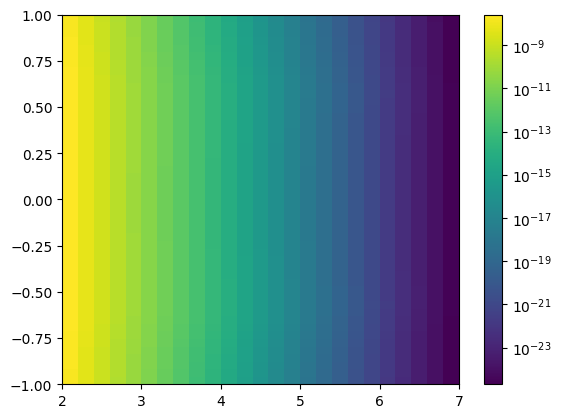

In [182]:
plt.pcolormesh(logE_bins, coszen_bins, bkg_eq.T, cmap='viridis', norm=LogNorm())
cb = plt.colorbar()

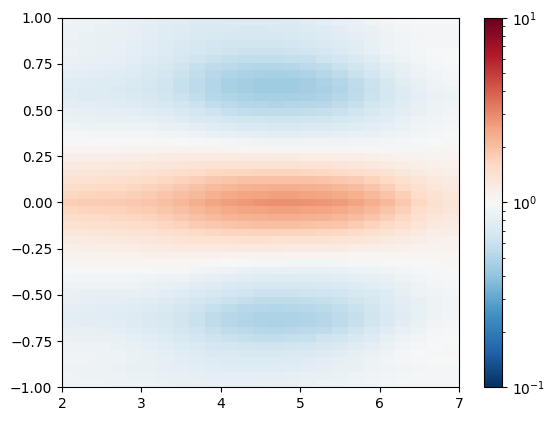

In [190]:
plt.pcolormesh(logE_mids, coszen_mids, (bckg_flux_vals.T / bkg_eq).T, cmap='RdBu_r', norm=LogNorm(vmin=1e-1, vmax=1e1))
cb = plt.colorbar()

In [95]:
bckg_flux_vals.shape

(49, 25)

In [252]:
expected_events = bckg_flux_vals * aeff_eq.T * LIVETIME * ewidth *hp.nside2pixarea(nside, degrees=False) #  np.diff(coszen_bins)[0]

(2.0, 7.0)

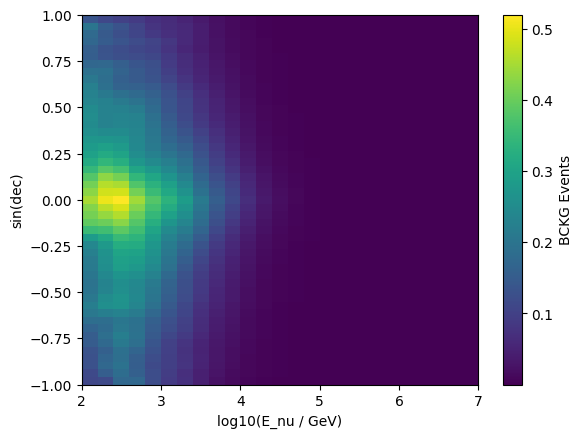

In [253]:
plt.pcolormesh(logE_bins, coszen_bins, expected_events, cmap='viridis') #norm=LogNorm())
cb = plt.colorbar()
cb.set_label("BCKG Events")
plt.ylabel("sin(dec)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 7)


# Source flux definition

In [254]:
def astro_flux(
    aeff_factor,
    emids,
    E0,
    gamma,
    phi_scaling,
    PHI_0,
    smear_energy=True
):
    """
    flux shape: dphi/dE = phi_0 * (E/E0) ** -gamma
    powerlaw parameters:
        * gamma
        * phi scaling (phi normalization will be phi_0 * phi scaling) 
          -> actual fit parameter will be of magnitude 1 instead of E-14
    """
    if hasattr(PHI_0, "__len__"):
        tmp = np.array([aeff_factor[i] * (emids/E0)**(-gamma) * phi * phi_scaling for i, phi in enumerate(PHI_0)])
    else:
        tmp = aeff_factor * (emids/E0)**(-gamma) * PHI_0 * phi_scaling
    #print(tmp.shape)
    if smear_energy:
        return energy_smearing(normed_kvals, tmp)
    else:
        return tmp

In [ ]:
ae

In [220]:
effa_template = np.ndarray((hp.nside2npix(nside), len(emids)))
#bckg_flux_per_pixel = np.ndarray((hp.nside2npix(nside), len(emids)))

decs = []
ras = []
#reshape effective area in nbins vs energy
for pix, flux in enumerate(pi0_flux_per_pixel):
    theta, phi = hp.pix2ang(nside, pix)
    dec = np.pi/2 - theta
    ra = phi
    #sindec = np.sin(dec)
    decs.append(dec)
    ras.append(ra)
    effa_template[pix] = array_source_interp(dec, aeff_eq)
    
    #azi, zen = rotate_events_to_local(ra,dec)
    #print(azi,zen)
    bckg_flux_per_pixel[pix] = array_source_interp(dec, bkg_eq, local=False)
    
#smoothed_bkg = np.ndarray((hp.nside2npix(nside), len(emids)))
'''for i in range(len(emids)):
    smoothed_bkg[:,i] = hp.smoothing(bckg_flux_per_pixel[:,i], sigma=np.radians(10))
'''

'for i in range(len(emids)):\n    smoothed_bkg[:,i] = hp.smoothing(bckg_flux_per_pixel[:,i], sigma=np.radians(10))\n'

In [221]:
'''for pix, flux in enumerate(pi0_flux_per_pixel):
    theta, phi = hp.pix2ang(nside, pix)
    #print(np.degrees(theta))
    bckg_flux_per_pixel[pix] = expected_events[np.digitize(np.cos(theta), bins=coszen_bins)-1]'''

'for pix, flux in enumerate(pi0_flux_per_pixel):\n    theta, phi = hp.pix2ang(nside, pix)\n    #print(np.degrees(theta))\n    bckg_flux_per_pixel[pix] = expected_events[np.digitize(np.cos(theta), bins=coszen_bins)-1]'

In [222]:
'''
time = None
azis, zens = rotate_events_to_local(ras,decs, time=time)
bckg_events_per_pixel = np.ndarray((hp.nside2npix(nside), len(emids)))
bckg_flux_per_pixel = np.ndarray((hp.nside2npix(nside), len(emids)))
for pix, flux in enumerate(pi0_flux_per_pixel):
    bckg_events_per_pixel[pix] = expected_events[np.digitize(np.cos(zens[pix]), bins=coszen_bins)-1]
    bckg_flux_per_pixel[pix] = bckg_flux_vals[np.digitize(np.cos(zens[pix]), bins=coszen_bins)-1]

    #bckg_flux_per_pixel[pix] = (np.pi/2 + zens[pix], bckg_flux_vals.T) #.T
'''

'\ntime = None\nazis, zens = rotate_events_to_local(ras,decs, time=time)\nbckg_events_per_pixel = np.ndarray((hp.nside2npix(nside), len(emids)))\nbckg_flux_per_pixel = np.ndarray((hp.nside2npix(nside), len(emids)))\nfor pix, flux in enumerate(pi0_flux_per_pixel):\n    bckg_events_per_pixel[pix] = expected_events[np.digitize(np.cos(zens[pix]), bins=coszen_bins)-1]\n    bckg_flux_per_pixel[pix] = bckg_flux_vals[np.digitize(np.cos(zens[pix]), bins=coszen_bins)-1]\n\n    #bckg_flux_per_pixel[pix] = (np.pi/2 + zens[pix], bckg_flux_vals.T) #.T\n'

In [257]:
#for i in range(25):
#    hp.mollview(np.log10(bckg_events_per_pixel[:,i]), rot=(180,0), 
#                unit='Events',title='Local Coords log10(Events) logE: {:.2}'.format(np.log10(emids[i])),)
#    hp.graticule(c='0.7')

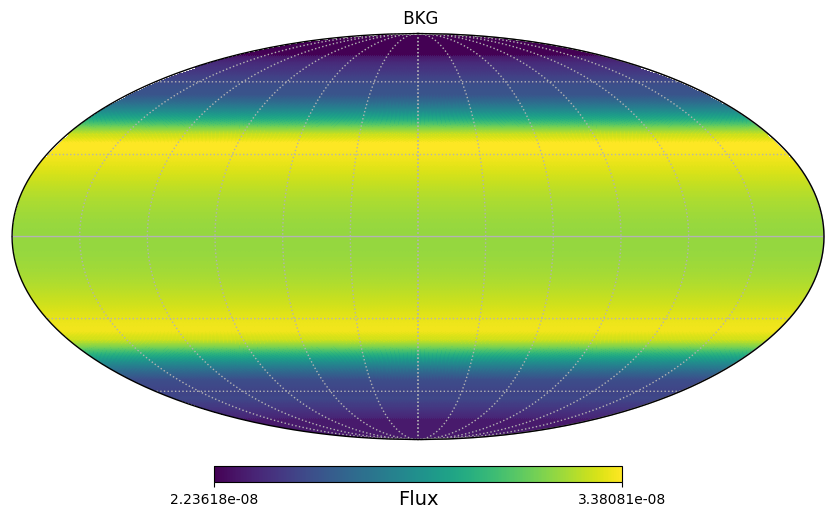

In [258]:
hp.mollview((np.sum(bckg_flux_per_pixel, axis=1)), rot=(180,0), 
            unit='Flux',title=' BKG'.format(time))
hp.graticule(c='0.7')

In [225]:
averaged_map = np.ndarray((hp.nside2npix(nside), len(emids)))
averaged_events_map = np.ndarray((hp.nside2npix(nside), len(emids)))

#dec average
dec_degs = np.arange(-90,90,2)
for j, map in enumerate(bckg_flux_per_pixel.T):
    for i, dec in enumerate(dec_degs):
        allpix = np.arange(0,hp.nside2npix(nside),1)
        theta, phi = hp.pix2ang(nside, allpix)
        mask = (np.pi/2 - theta > np.radians(dec - 3)) & (np.pi/2 - theta < np.radians(dec + 3) )
        idx = np.where(mask)
        #print(idx)
        averaged_map[idx,j] = np.mean(map[idx]) 
for j, map in enumerate(bckg_events_per_pixel.T):
    for i, dec in enumerate(dec_degs):
        allpix = np.arange(0,hp.nside2npix(nside),1)
        theta, phi = hp.pix2ang(nside, allpix)
        mask = (np.pi/2 - theta > np.radians(dec - 3)) & (np.pi/2 - theta < np.radians(dec + 3) )
        idx = np.where(mask)
        #print(idx)
        averaged_events_map[idx,j] = np.mean(map[idx]) #*hp.nside2pixarea(nside, degrees=False))

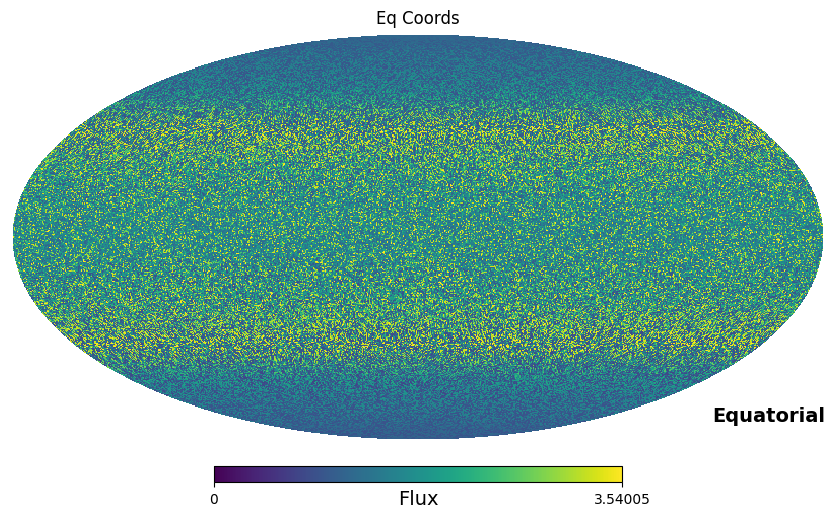

In [226]:
hp.mollview(np.sum(bckg_events_per_pixel, axis=1), rot=(180,0), min=0,coord='C' ,
            unit='Flux',title='Eq Coords')

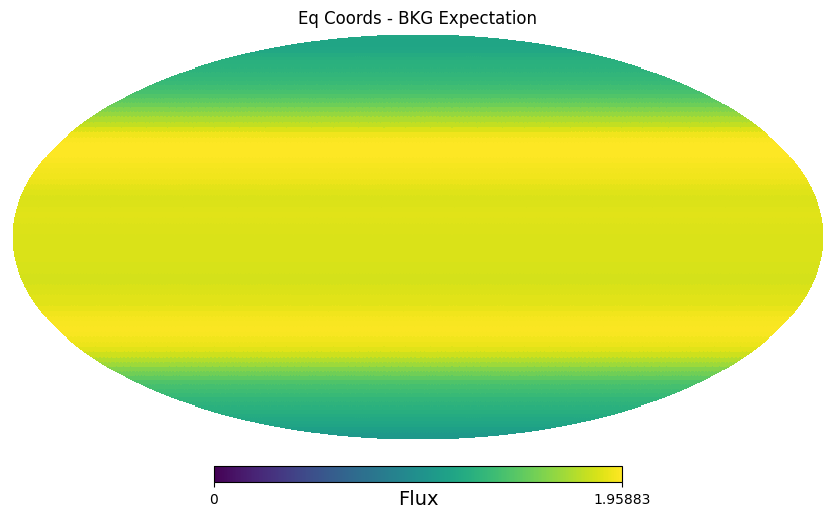

In [140]:
hp.mollview(np.sum(averaged_events_map, axis=1), rot=(180,0), min=0,
            unit='Flux',title='Eq Coords - BKG Expectation')

In [227]:
k_s = []
aeff_factor_signal = (
    effa_template*  LIVETIME * ewidth #* e_psi2_grid
    )    
print(aeff_factor_signal.shape)

k_s = astro_flux(
    aeff_factor_signal, #what to do here?  
    emids,
    E0,
    pi0_spectrum,
    1,
    PHI_0=pi0_flux_per_pixel,
    smear_energy=False,
)
print(k_s.shape)


(196608, 25)
(196608, 25)


In [228]:
k_s.sum()

67.75528308706026

In [229]:
##smear the template with ang unc bins
angres = np.linspace(1,.05,25)

In [230]:
angres_pstracks = [2.286, 1.487,
2.309, 1.450,
2.335, 1.424,
2.355, 1.393,
2.386, 1.367,
2.410, 1.341,
2.433, 1.314,
2.457, 1.287,
2.476, 1.256,
2.512, 1.216,
2.557, 1.178,
2.592, 1.152,
2.628, 1.126,
2.670, 1.087,
2.907, 0.915,
2.963, 0.886,
3.570, 0.615,
3.632, 0.592,
3.697, 0.578,
3.762, 0.560,
3.827, 0.541,
3.889, 0.520,
3.951, 0.504,
4.015, 0.488,
4.080, 0.479,
4.145, 0.466,
4.210, 0.452,
4.275, 0.439,
4.339, 0.423,
4.404, 0.418,
4.469, 0.404,
4.529, 0.403,
4.811, 0.361,
4.872, 0.356,
4.941, 0.348,
5.487, 0.295,
5.553, 0.298,
5.620, 0.287,
5.679, 0.286,
5.748, 0.277,
5.813, 0.272,
5.878, 0.271,
6.275, 0.252,
6.343, 0.247,
6.408, 0.246,
6.477, 0.242,
6.534, 0.244,
6.604, 0.236,
6.667, 0.229,
6.732, 0.231,
6.797, 0.228,
6.862, 0.229,
6.926, 0.225,
6.991, 0.224,
7.056, 0.222,
7.121, 0.218,
7.189, 0.218,
7.245, 0.220,
7.321, 0.219,
7.386, 0.218,
7.451, 0.219,
7.515, 0.222,
7.704, 0.217,
7.769, 0.213,
7.834, 0.212,
7.899, 0.208,
7.964, 0.205,
8.028, 0.201,
8.078, 0.199]


In [231]:
angres = np.interp(emids, angres_pstracks[::2], angres_pstracks[1::2])
pone_angres = angres / 3

In [232]:
smeared_template = np.ndarray((hp.nside2npix(nside), len(emids)))
for i, angerr in enumerate(pone_angres):
    print('Smearing template for Energy {:2f}: {:.1f} deg'.format(emids[i], angerr), flush=True, end='\r')
    template = k_s[:,i]
    smeared_template[:,i] = hp.smoothing(template, sigma=np.radians(angerr))

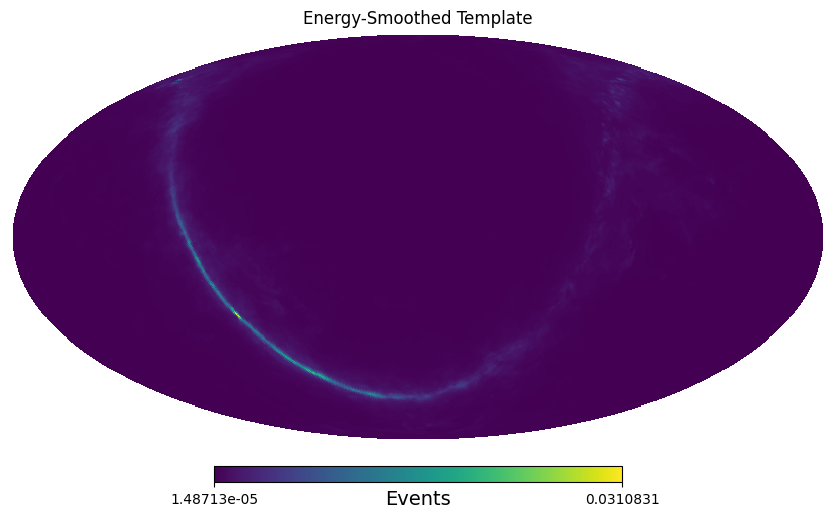

In [233]:
hp.mollview(np.sum(smeared_template, axis=1), unit='Events',rot=(180,0), title='Energy-Smoothed Template')

In [234]:
### bkg_b

In [235]:
aeff_factor_bckg = (
        effa_template
        * LIVETIME
        * ewidth
        * hp.nside2pixarea(nside, degrees=False) # solid angle approx. 2x?
    )#* bckg_grid * 1
print(aeff_factor_bckg.shape)
k_b = aeff_factor_bckg * bckg_flux_per_pixel
#k_b = atmo_background(aeff_factor_bckg , averaged_map, smear_energy=False, smooth_bkg=False)
#k_b = atmo_background(aeff_factor_bckg, array_source_interp(dec, bckg_flux_vals.T).T)

(196608, 25)


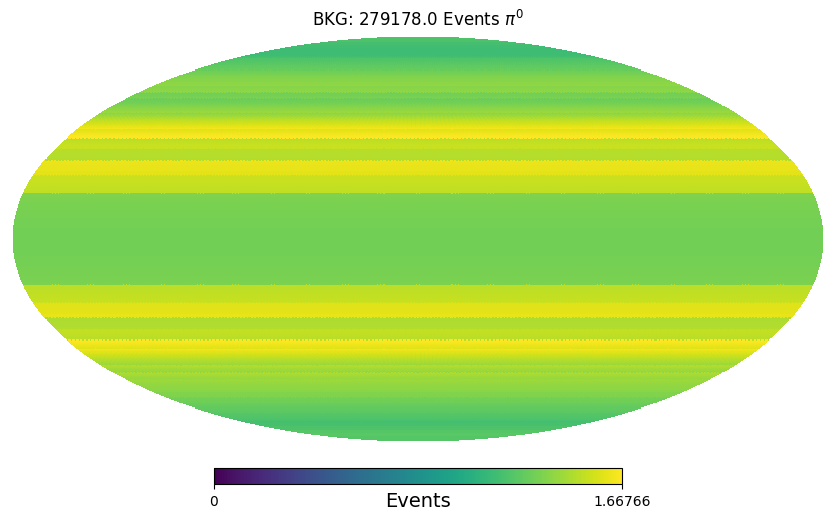

In [236]:
hp.mollview(np.sum(k_b, axis=1), rot=(180,0),unit='Events', min=0,
            title='BKG: {:.1f} Events $\pi^0$'.format(k_b.sum()))

In [237]:
k_b.sum()
k_s.sum()

67.75528308706026

In [152]:
mu_b_base = deepcopy(aeff_factor_bckg)
mu_s_base = deepcopy(aeff_factor_signal)

In [153]:
#k_i = k_b + smeared_template
k_i = averaged_events_map + smeared_template

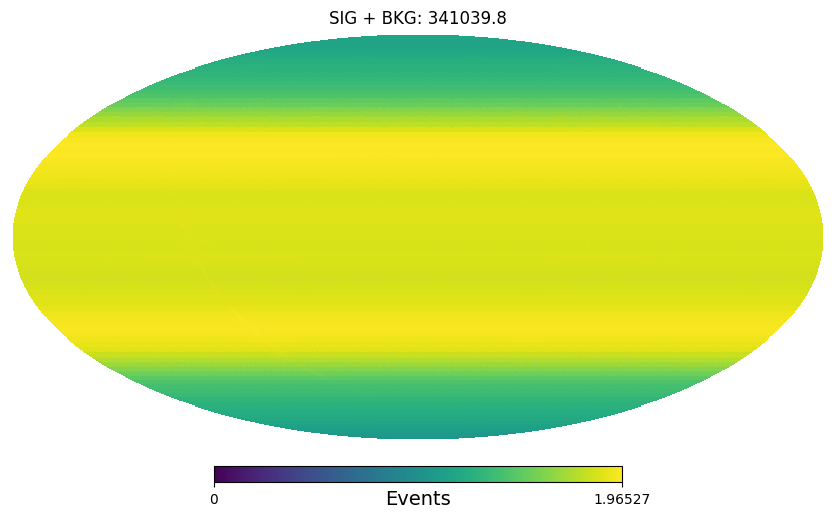

In [154]:

hp.mollview( np.sum(k_i, axis=1), rot=(180,0), unit='Events', min=0, title='SIG + BKG: {:.1f}'.format(k_i.sum()))
plt.tight_layout()

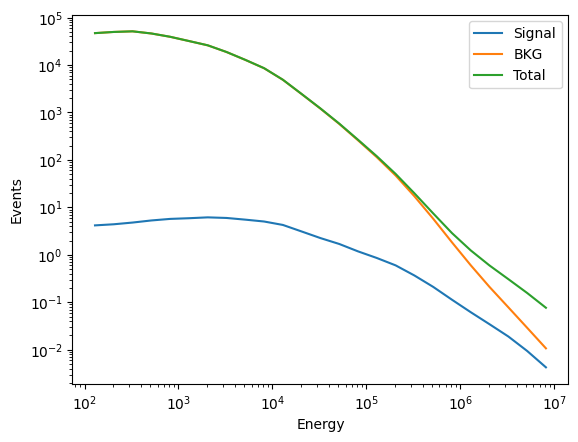

In [238]:
plt.plot(emids, np.sum(smeared_template, axis=0), label='Signal')
plt.plot(emids, np.sum(averaged_events_map, axis=0), label='BKG')
plt.plot(emids, np.sum(k_i, axis=0), label='Total')

plt.loglog()
#plt.title('Signal Events')
plt.xlabel('Energy')
plt.ylabel('Events')
plt.legend()

In [239]:
    mu_s = astro_flux(
        mu_s_base, emids, E0, pi0_spectrum, 1, PHI_0=pi0_flux_per_pixel, 
        smear_energy=False
    )

In [240]:
np.sum(k_i)

341383.9816522591

In [241]:
averaged_events_map[:,0].shape

(196608,)

In [242]:
atmo_background(
        mu_b_base, bckg_flux_per_pixel, 
        smear_energy=False, smooth_bkg=True
    )[:,0].shape

(196608,)

In [243]:
 (atmo_background(
        mu_b_base, bckg_flux_per_pixel, 
        smear_energy=False, smooth_bkg=False
    )[:,2] - averaged_events_map[:,2])

array([-0.00861706, -0.00861706, -0.00861706, ...,  0.05137407,
        0.05137407,  0.05137407])

In [250]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0=E0,
    verbose=False
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling

    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    """
    if verbose:
        print(x)
    #mu_b = x[0]*atmo_background(
    #    mu_b_base, bckg_flux_per_pixel, 
    #    smear_energy=False, smooth_bkg=False
    #)
    #mu_b = x[0] * averaged_events_map 
    #mu_s = x[1] * smeared_template
    mu_b = x[0] *aeff_factor_bckg * bckg_flux_per_pixel
    
    mu_s = astro_flux(
        mu_s_base, emids, e_0, pi0_spectrum, x[1], 
        PHI_0=pi0_flux_per_pixel, 
        smear_energy=False
    )
    
    #print(mu_b.shape, mu_s.shape)
    mu_i = mu_s + mu_b
    # -2 Log Likelihood (B/S)
    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i,
            #- 0.5 * np.log(2 * np.pi * k_i)
            #+ k_i
            #- k_i * np.log(k_i),
            0,
        )
    )
    

In [251]:
# define the fitting functions with all parameters
# background only, 1 free parameter
local_llh = lambda x: ps_llh_2d_composite(
    (x[0], 0), mu_b_base, mu_s_base, k_i
)
# background + signal, 3 free parameters

# ... and fit both hypotheses!
out_bckg = minimize(
    local_llh,
    x0=(1.2,),
    options={'maxiter' : 100}
    #epsilon=.01,
    #approx_grad=True,
    
)

print('Function Calls: {}'.format(out_bckg['nfev']))

#print(out_bckg)
print("Bckg-only normalization:", out_bckg['x'])
global_llh = lambda x: ps_llh_2d_composite(
    (x), mu_b_base, mu_s_base, k_i
)


out_comp = minimize(
    global_llh,
    #epsilon=(.0001, .5),
    x0=(1.1,  0.7),
    #options={'maxiter' : 200}
    #approx_grad=True,
)
#print(out_comp)
print('Function Calls: {}'.format(out_comp['nfev']))

print("Signal fit parameters:", out_comp['x'])

# calculate p-value and significance with Wilks' and -2- 1 d.o.f
pval = chi2.sf(out_bckg['fun'] - out_comp['fun'], 2)

significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE: {:.6f}".format(pval), "SIGNIFICANCE: {:.3f}".format(significance))


Function Calls: 76
Bckg-only normalization: [1.22281851]
Function Calls: 189
Signal fit parameters: [1.22171303 4.03601568]
P-VALUE: 0.000162 SIGNIFICANCE: 3.772


In [163]:
sig = []
pvals = []
sig_multipliers = [5.5]
for sig_multiplier in sig_multipliers:
    k_i = averaged_events_map + sig_multiplier*smeared_template
        # define the fitting functions with all parameters
    # background only, 1 free parameter
    local_llh = lambda x: ps_llh_2d_composite(
        (x[0], 0), mu_b_base, sig_multiplier*mu_s_base, k_i
    )
    # background + signal, 3 free parameters

    # ... and fit both hypotheses!
    out_bckg = minimize(
        local_llh,
        x0=(1.2,),
        options={'maxiter' : 100}
        #epsilon=.01,
        #approx_grad=True,

    )

    print('Function Calls: {}'.format(out_bckg['nfev']))

    #print(out_bckg)
    print("Bckg-only normalization:", out_bckg['x'])
    global_llh = lambda x: ps_llh_2d_composite(
        (x), mu_b_base, sig_multiplier*mu_s_base, k_i
    )


    out_comp = minimize(
        global_llh,
        #epsilon=(.0001, .5),
        x0=(1.1,  0.8),
        #options={'maxiter' : 200}
        #approx_grad=True,
    )
    #print(out_comp)
    print('Function Calls: {}'.format(out_comp['nfev']))

    print("Signal fit parameters:", out_comp['x'])

    # calculate p-value and significance with Wilks' and -2- 1 d.o.f
    pval = chi2.sf(out_bckg['fun'] - out_comp['fun'], 2)

    significance = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE: {:.6f}".format(pval), "SIGNIFICANCE: {:.3f}".format(significance))
    sig.append(significance)
    pvals.append(pval)

Function Calls: 22
Bckg-only normalization: [1.00123358]



KeyboardInterrupt



(0.0, 5.0)

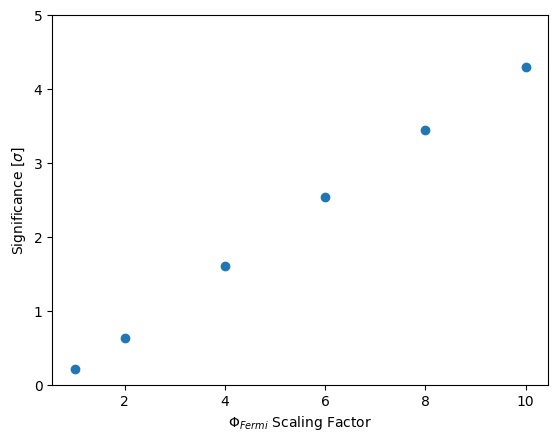

In [63]:
plt.scatter(sig_multipliers, sig)
plt.xlabel('$\Phi_{Fermi}$ Scaling Factor')
plt.ylabel('Significance [$\sigma$]')
plt.ylim(0,5)

In [ ]:
'''sig_llh = []
xs = np.linspace(0,1.5,25)
for x in xs:
    sig_llh.append(ps_llh_2d_composite(
        (1,x), mu_b_base, mu_s_base, k_i
    ))'''

In [ ]:
'''plt.plot(xs, np.array(sig_llh))
plt.title('Signal LLH space with BKG nominal')
plt.xlabel('Sig Norm')'''

In [ ]:
'''bkg_llh = []
xs = np.linspace(.1,2,25)
for x in xs:
    bkg_llh.append(ps_llh_2d_composite(
        (x,0), mu_b_base, mu_s_base, k_i
    ))'''

In [ ]:
'''plt.plot(xs, np.array(bkg_llh))
plt.title('BKG LLH space with SIG=0')
plt.xlabel('Bkg-Norm')'''